In [1]:
# importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
# load dataset
dataset=pd.read_csv('./iris.csv')
dataset.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [3]:
# Overview of Dataset Characteristics
dataset.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [4]:
#Create x and y variables
x = dataset.drop('species', axis=1).values
Y = dataset['species'].values

#Load Library for Training
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,Y,test_size = 0.2,stratify=Y,random_state = 100)

#Fix the imbalanced Classes
from imblearn.over_sampling import SMOTE
smt=SMOTE(random_state=100)
x_train_smt,y_train_smt = smt.fit_resample(x_train,y_train)

#Scale the Data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()  
X_train = sc.fit_transform(x_train_smt)  
X_test = sc.transform(x_test)

x_2=sc.transform(x)

#Import Dependencies
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix  

Using TensorFlow backend.


In [5]:
# Determine Number of Components for DR
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix

#PCA Ratios
pca_none = PCA(n_components=None,random_state=100)
X_pca = pca_none.fit(x_2, Y)
pca_var_ratios = pca_none.explained_variance_ratio_

#LDA Ratios
lda_none = LinearDiscriminantAnalysis(n_components=None)
X_lda = lda_none.fit(x_2, Y)
lda_var_ratios = lda_none.explained_variance_ratio_

#SVM Ratios
X_sparse = csr_matrix(x_2)
tsvd = TruncatedSVD(n_components=X_sparse.shape[1]-1)
X_tsvd = tsvd.fit(x_2)
tsvd_var_ratios = tsvd.explained_variance_ratio_

# Create a function
def select_n_components(var_ratio, goal_var: float) -> int:
    # Set initial variance explained so far
    total_variance = 0.0
    
    # Set initial number of features
    n_components = 0
    
    # For the explained variance of each feature:
    for explained_variance in var_ratio:
        
        # Add the explained variance to the total
        total_variance += explained_variance
        
        # Add one to the number of components
        n_components += 1
        
        # If we reach our goal level of explained variance
        if total_variance >= goal_var:
            # End the loop
            break
            
    # Return the number of components
    return n_components

#Number of components
n_comppca=select_n_components(pca_var_ratios, 0.95)
n_complda=select_n_components(lda_var_ratios, 0.95)
n_compsvd=select_n_components(tsvd_var_ratios, 0.95)

In [6]:
#Explained Variance

#Create PCA
pca = PCA(n_components=n_comppca,random_state=100)  
X_trainpca = pca.fit_transform(X_train, y_train_smt)  
X_testpca = pca.transform(X_test)  

#Create lda
lda = LinearDiscriminantAnalysis(n_components=n_complda)  
X_trainlda = lda.fit_transform(X_train, y_train_smt)  
X_testlda = lda.transform(X_test)

#Create SVM
SVD = TruncatedSVD(n_components=n_compsvd)
X_trainsvd = SVD.fit_transform(X_train, y_train_smt)  
X_testsvd = SVD.transform(X_test) 

#Explained Variance and Plot
print('Explained Variance-PCA:',np.round(pca.explained_variance_ratio_,2))
print('Explained Variance-LDA:',np.round(lda.explained_variance_ratio_,2))
print('Explained Variance-SVD:',np.round(tsvd.explained_variance_ratio_,2))

Explained Variance-PCA: [0.73 0.23]
Explained Variance-LDA: [0.99]
Explained Variance-SVD: [0.72 0.24 0.04]


In [7]:
# Predict on test data on Random Forest Classifier - PCA
classifier = RandomForestClassifier(n_estimators=100,max_depth=2, random_state=100)
classifier.fit(X_trainpca, y_train_smt)
y_pred = classifier.predict(X_testpca) 

#Evaluate the Algorithm
target_names=['setosa','versicolor','virginica']
print(confusion_matrix(y_test,y_pred))  
print(classification_report(y_test,y_pred,target_names=target_names))
print('\n Number of Components Used:', n_comppca)

[[10  0  0]
 [ 0  9  1]
 [ 0  5  5]]
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.64      0.90      0.75        10
   virginica       0.83      0.50      0.62        10

    accuracy                           0.80        30
   macro avg       0.83      0.80      0.79        30
weighted avg       0.83      0.80      0.79        30


 Number of Components Used: 2


In [8]:
#Feature Distribution -PCA (Using Optimum Number)

'''
Each column of the matrix shows the weights in the linear 
combination which obtains the corresponding principal component
'''
index=dataset.drop('species', axis=1).columns
FD=pd.DataFrame(np.round(pca.components_.T,2),index)
FD.columns += 1
FD.add_prefix('PC_')

,PC_1,PC_2
sepal_length,0.52,0.37
sepal_width,-0.27,0.93
petal_length,0.58,0.03
petal_width,0.56,0.07


In [9]:
# Predict on test data on Random Forest Classifier - SVD
classifier = RandomForestClassifier(n_estimators=100,max_depth=2, random_state=100)
classifier.fit(X_trainsvd, y_train_smt)
y_pred3 = classifier.predict(X_testsvd) 

#Evaluate the Algorithm
target_names=['setosa','versicolor','virginica']
print(confusion_matrix(y_test,y_pred3))  
print(classification_report(y_test,y_pred3,target_names=target_names))
print('\n Number of Components Used:', n_compsvd)

[[10  0  0]
 [ 0  9  1]
 [ 0  5  5]]
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.64      0.90      0.75        10
   virginica       0.83      0.50      0.62        10

    accuracy                           0.80        30
   macro avg       0.83      0.80      0.79        30
weighted avg       0.83      0.80      0.79        30


 Number of Components Used: 2


In [10]:
#Feature Distribution -SVD (Using Optimum Number)

'''
Each column of the matrix shows the weights in the linear 
combination which obtains the corresponding principal component
'''
index=dataset.drop('species', axis=1).columns
FD=pd.DataFrame(np.round(SVD.components_.T,2),index)
FD.columns += 1
FD.add_prefix('PC_')

,PC_1,PC_2
sepal_length,0.52,0.37
sepal_width,-0.27,0.93
petal_length,0.58,0.03
petal_width,0.56,0.07


In [11]:
# Predict on test data on Random Forest Classifier - LDA
classifier = RandomForestClassifier(n_estimators=100,max_depth=2, random_state=100)
classifier.fit(X_trainlda, y_train_smt)
y_pred2 = classifier.predict(X_testlda) 

#Evaluate the Algorithm
target_names=['setosa','versicolor','virginica']
print(confusion_matrix(y_test,y_pred2))  
print(classification_report(y_test,y_pred2,target_names=target_names))
print('\n Number of Components Used:', n_complda)

[[10  0  0]
 [ 0 10  0]
 [ 0  1  9]]
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.91      1.00      0.95        10
   virginica       1.00      0.90      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30


 Number of Components Used: 1


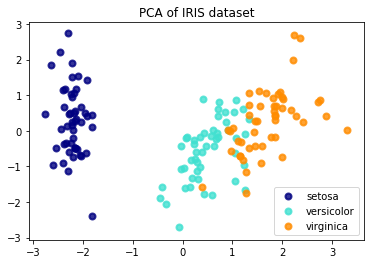

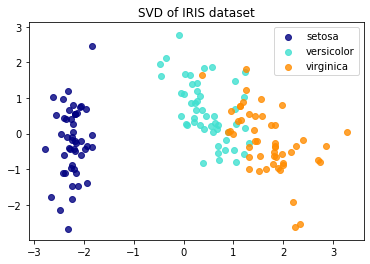

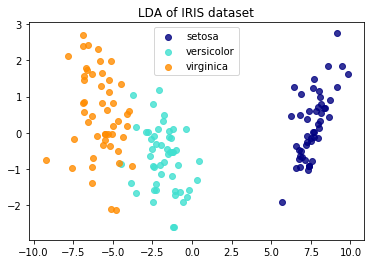

In [12]:
#Graphing for PCA, LDA and SVD
pca = PCA(n_components=2,random_state=100)
X_r = pca.fit(x_2).transform(x_2)

lda = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda.fit(x_2, Y).transform(x_2)

lda = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda.fit(x_2, Y).transform(x_2)

SVD = TruncatedSVD(n_components=2)
X_r3 = SVD.fit(x_2, Y).transform(x_2)

target_names = ['setosa', 'versicolor', 'virginica']

plt.figure()
colors = ['navy', 'turquoise', 'darkorange']
lw = 2

for color, i, target_name in zip(colors, ['setosa', 'versicolor', 'virginica'], target_names):
    plt.scatter(X_r[Y == i, 0], X_r[Y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of IRIS dataset')

plt.figure()
for color, i, target_name in zip(colors, ['setosa', 'versicolor', 'virginica'], target_names):
    plt.scatter(X_r3[Y == i, 0], X_r3[Y == i, 1], alpha=.8, color=color,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('SVD of IRIS dataset')

plt.figure()
for color, i, target_name in zip(colors, ['setosa', 'versicolor', 'virginica'], target_names):
    plt.scatter(X_r2[Y == i, 0], X_r2[Y == i, 1], alpha=.8, color=color,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('LDA of IRIS dataset')

plt.show()